In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, explained_variance_score

In [2]:
# Load data
data = pd.read_csv('../../AIBetic2Dataset/HbA1c_prediction_dataset.csv')

### Data cleaning and Pre-processing

In [3]:
# Drop patient_no column if it exists
if 'patient_no' in data.columns:
    data = data.drop('patient_no', axis=1)

# Drop rows with missing values    
data = data.ffill().dropna()

# Print head of the data
print(data.head())

         date gender  age    bmi  glucose_level  HbA1c
0  2024-01-31   Male   56  37.77           7.41  10.63
1  2024-02-01   Male   56  37.77           6.95  10.63
2  2024-02-02   Male   56  37.77           5.30  10.63
3  2024-02-03   Male   56  37.77           5.02  10.63
4  2024-02-04   Male   56  37.77           6.39  10.63


In [9]:
# Drop patient_no column if it exists
if 'patient_no' in data.columns:
    data = data.drop('patient_no', axis=1)

# Drop rows with missing values    
data = data.ffill().dropna()

# Create separate scalers for each feature
scaler_glucose = MinMaxScaler()
data['glucose_level'] = scaler_glucose.fit_transform(data[['glucose_level']])

# Print head of the data
print(data.head())

# Constants for the model
SEQUENCE_LENGTH = 20  # Number of glucose readings in each sequence

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        end_ix = i + seq_length
        if end_ix > len(data):
            break
        x_seq = data['glucose_level'].iloc[i:end_ix].values
        y_seq = data['HbA1c'].iloc[end_ix]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

# Prepare sequences
X_all, y_all = create_sequences(data, SEQUENCE_LENGTH)

# Reshape input to be [samples, time steps, features]
X_all = X_all.reshape((X_all.shape[0], SEQUENCE_LENGTH, 1))  # Only one feature, glucose levels

print(X_all.shape)

# Splitting data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

         date gender  age    bmi  glucose_level  HbA1c
0  2024-01-31   Male   56  37.77       0.555822  10.63
1  2024-02-01   Male   56  37.77       0.500600  10.63
2  2024-02-02   Male   56  37.77       0.302521  10.63
3  2024-02-03   Male   56  37.77       0.268908  10.63
4  2024-02-04   Male   56  37.77       0.433373  10.63
(8980, 20, 1)


### LSTM model creation

Epoch 1/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.7544 - val_loss: 1.7086
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2433 - val_loss: 0.9231
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0370 - val_loss: 0.7576
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8529 - val_loss: 0.6990
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7786 - val_loss: 0.5997
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6984 - val_loss: 0.5636
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808 - val_loss: 0.5450
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6326 - val_loss: 0.5043
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6247 - val_loss: 0.5551
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6359 - val_loss: 0.5022
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6038 - val_loss: 0.4848
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

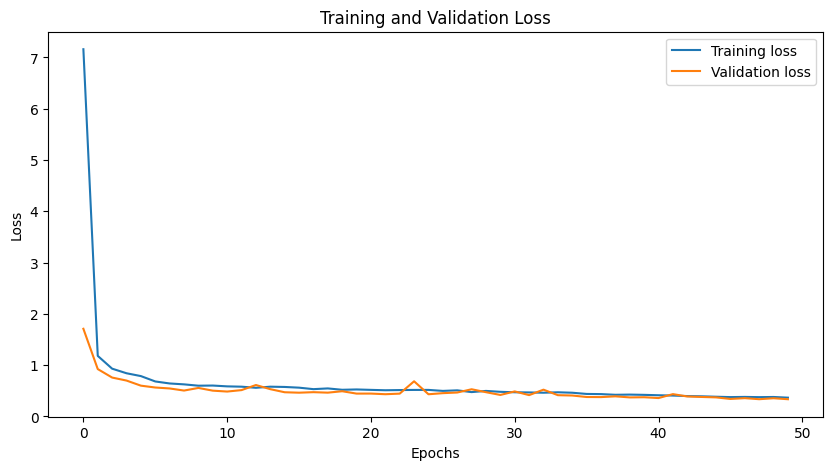

In [5]:
# Define a simpler LSTM model
model = Sequential([
    LSTM(20, activation='relu', input_shape=(SEQUENCE_LENGTH, 1)), # 20 units in the LSTM layer
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model with validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot training & validation loss to check for overfitting
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)

# Predict using the trained model
predictions = model.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
evs = explained_variance_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'EVS: {evs}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.2571
Test loss: 0.27635300159454346
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.27635303041547477
RMSE: 0.5256929050457831
MAE: 0.32938539971245656
R2: 0.9504623083409814
EVS: 0.9513207882202979
